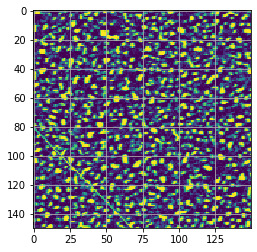

In [1]:
# preamble
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from crosspy import DIC, Imset, fxcorr
import os
import cv2

# folder path

folder_path=Path(r'/Users/tom/Documents/GitHub/crosspy/data/Subset_tester/')
Images = Imset(folder_path,'tif')

# Image crop

crop_on = False

if crop_on:
    img = Images.imload([0,1])
    y = 175
    h = 1000
    x = 525
    w = 1000
    Images = img[y:y+h, x:x+w, :]
else:
    Images = Images.imload([0,1])
   
fig = plt.figure()
ax = fig.gca()
ax.imshow(Images[:,:,1])
#ax.set_xticks(np.arange(0, Images.shape[0], Images.shape[0]/10))
#ax.set_yticks(np.arange(0, Images.shape[1], Images.shape[1]/10))
plt.grid()


10000
Running sequential DIC on image pair 1 of 1 ...
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    7.7s
[Parallel(n_jobs=4)]: Done 212 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 3028 tasks      | elapsed:   12.7s
[Parallel(n_jobs=4)]: Done 7060 tasks      | elapsed:   19.3s
[Parallel(n_jobs=4)]: Done 9993 out of 10000 | elapsed:   24.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 10000 out of 10000 | elapsed:   24.2s finished
... Completed in (s) 24.91003108024597
Calculating strain on map 1 of 1 ...
... Completed in (s) 12.007100820541382
Quick plotting strains


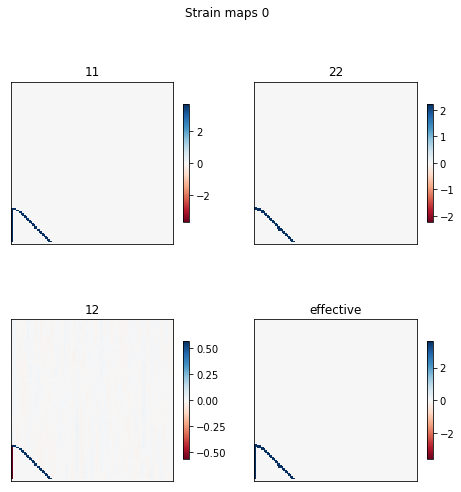


*** Profile printout saved to text file 'prun0'. 


In [2]:
%%prun -s cumulative -q -l 10 -T prun0
# Image crop

roi_1stpass = dict(size_pass = 50, overlap_percentage = 99, xcf_mesh=50)
filter_settings = [4,2,15,8]
# first pass

dic_1stpass = DIC(Images,roi_1stpass,filter_settings)

print(dic_1stpass.n_subsets)
dic_1stpass.run_sequential(cores=4,hs=False)

# dic_1stpass.plot_displacements()
dic_1stpass.calculate_strain()
dic_1stpass.plot_strains()

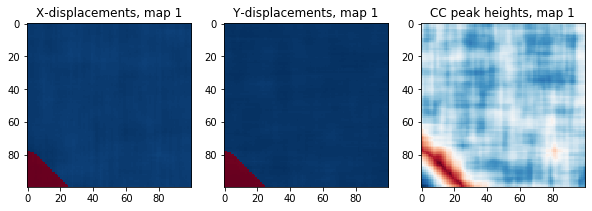

[]

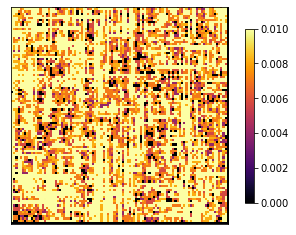

In [4]:
dic_1stpass.plot_displacements()

eff = dic_1stpass.strain_eff[:,:,0]
e11 = dic_1stpass.strain_11[:,:,0]
e22 = dic_1stpass.strain_22[:,:,0]
e12 = dic_1stpass.strain_12[:,:,0]
fig,ax = plt.subplots()


im1 = ax.imshow(eff, vmin=0,vmax=0.01, cmap="inferno")

fig.colorbar(im1, ax=ax, shrink=0.8)

ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

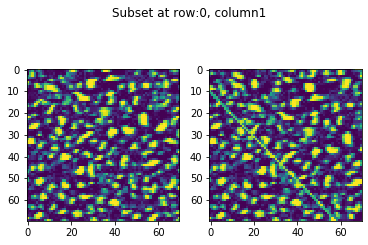

In [18]:
import cv2
filter_settings=[4,2,15,8]
ims = Images
#settings for heaviside pass
roi_disc = dict(size_pass = 70, overlap_percentage = 80, xcf_mesh=30)
dic_disc = DIC(ims, roi_disc,filter_settings)

# Function to plot selected subsets

def get_subsets(ims, row=3, col=1, roi_settings=None):
    if roi_settings==None:
        roi_settings = dict(
            size_pass = 100, 
            overlap_percentage = 70, 
            xcf_mesh=250)
    x0 = (col) * roi_settings['size_pass']
    x1 = x0 + roi_settings['size_pass']
    y0 = (row) * roi_settings['size_pass']
    y1 = y0 + roi_settings['size_pass']
    
    fig, axs = plt.subplots(1, 2)
    fig.suptitle('Subset at row:{}, column{}'.format(row,col))
    images = []
    for i in range(0,ims.shape[2]):
        images.append(axs[i].imshow(ims[x0:x1, y0:y1, i]))
        
    subsets = ims[x0:x1, y0:y1, :]
    return subsets

    
# Select a subset, here at row 20, column 20

#subsets = get_subsets(ims,5, 0, roi_disc) # has slip
subsets = get_subsets(ims,0,1, roi_disc) # has no slip


In [19]:
import numpy as np
from scipy.signal import fftconvolve

def ncc(b, a, mode="full"):
    """
    b is deformed subset
    a is reference subset

    This is a matlab port following Ujash Joshi, University of Toronto, 2017
    """

    # If this happens, it is probably a mistake
    if np.ndim(b) > np.ndim(a) or \
            len([i for i in range(np.ndim(b)) if b.shape[i] > a.shape[i]]) > 0:
        print("normxcorr2: TEMPLATE larger than IMG. Arguments may be swapped.")

    template = b - np.mean(b)
    image = a - np.mean(a)

    a1 = np.ones(template.shape)
    # Faster to flip up down and left right then use fftconvolve instead of scipy's correlate
    ar = np.flipud(np.fliplr(template))
    out = fftconvolve(image, ar.conj(), mode=mode)
    unout = out
    image = fftconvolve(np.square(image), a1, mode=mode) - \
            np.square(fftconvolve(image, a1, mode=mode)) / (np.prod(template.shape))

    # plt.imshow(image.real)

    # Remove small machine precision errors after subtraction
    image[np.where(image < 0)] = 0

    template = np.sum(np.square(template))
    out = out / np.sqrt(image * template)

    # Remove any divisions by 0 or very close to 0
    out[np.where(np.logical_not(np.isfinite(out)))] = 0

    CCmax=np.abs(np.amax(out))
    loc=np.argmax(out)
    loc1,loc2=np.unravel_index(loc,out.shape)

    row_shift=loc1-a.shape[0]
    col_shift=loc2-a.shape[0]

    return col_shift, row_shift, CCmax

ncc(subsets[:,:,0],subsets[:,:,1])

(9, 8, 0.5556720441893284)

In [20]:
from crosspy.XCF import fxcorr
from crosspy.XCF import plan_ffts

dic_2ndpass=dic_1stpass
ffts=plan_ffts(dic_1stpass)

fxcorr(subsets[:,:,0],subsets[:,:,1],dic_2ndpass,ffts)

(6.96, 6.54, 16562440126.726496)

In [21]:
import pyfftw
class fftwconvolve:
    def __init__(self, A, B, domain, threads=8):
        MK =  B.shape[0]
        NK = B.shape[1]
        M = A.shape[0]
        N = A.shape[1]

        if domain =="same":
            self.Y = M
            self.X = N
        elif domain == "valid":
            self.Y = M - MK + 1
            self.X = N - NK + 1
        elif domain == "full":
            self.Y = M + MK - 1
            self.X = N + NK - 1

        self.M = M + MK - 1
        self.N = N + NK - 1

        a = np.pad(A, ((0, MK - 1), (0, NK - 1)), mode='constant')
        b = np.pad(B, ((0, M - 1), (0, N - 1)), mode='constant')

        self.fft_A_obj = pyfftw.builders.rfft2(a, s=(self.M, self.N), threads=threads)
        self.fft_B_obj = pyfftw.builders.rfft2(b, s=(self.M, self.N), threads=threads)
        self.ifft_obj = pyfftw.builders.irfft2(self.fft_A_obj.output_array, s=(self.M, self.N), threads=threads)


        self.offset_Y = int(np.floor((self.M - self.Y)/2))
        self.offset_X = int(np.floor((self.N - self.X)/2))

    def __call__(self, A, B):
        MK =  B.shape[0]
        NK = B.shape[1]
        M = A.shape[0]
        N = A.shape[1]

        a = np.pad(A, ((0, MK - 1), (0, NK - 1)), mode='constant')
        b = np.pad(B, ((0, M - 1), (0, N - 1)), mode='constant')

        return self.ifft_obj(self.fft_A_obj(a) * self.fft_B_obj(b))[self.offset_Y:self.offset_Y + self.Y, self.offset_X:self.offset_X + self.X]

In [22]:
conv=fftwconvolve(subsets[:,:,0],subsets[:,:,1],'full')
c=conv(subsets[:,:,0],subsets[:,:,1])

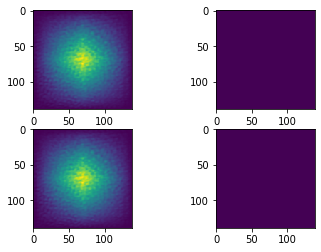

In [23]:
c=conv(subsets[:,:,0],subsets[:,:,1])
c2=fftconvolve(subsets[:,:,0],subsets[:,:,1], 'full')

fig,((ax1, ax2), (ax3, ax4))=plt.subplots(nrows=2,ncols=2) 
ax1.imshow(c.real) 
ax2.imshow(c.imag) 
ax3.imshow(c2.real) 
ax4.imshow(c2.imag)

In [24]:
%timeit conv(subsets[:,:,0],subsets[:,:,1])
%timeit fftconvolve(subsets[:,:,0],subsets[:,:,1], 'full')

3.85 ms ± 280 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.12 ms ± 15.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [25]:
def ncc_fftw(b, a, conv, mode='full'):
    """
    b is deformed subset
    a is reference subset
    conv is the fftw convolution class

    This is a matlab port following Ujash Joshi, University of Toronto, 2017
    Edited by TPM for crosspy and fftw implementation
    """

    # If this happens, it is probably a mistake
    if np.ndim(b) > np.ndim(a) or \
            len([i for i in range(np.ndim(b)) if b.shape[i] > a.shape[i]]) > 0:
        print("normxcorr2: TEMPLATE larger than IMG. Arguments may be swapped.")

    template = b - np.mean(b)
    image = a - np.mean(a)

    a1 = np.ones(template.shape)
    # Faster to flip up down and left right then use fftconvolve instead of scipy's correlate
    ar = np.flipud(np.fliplr(template))
    out = conv(image, ar.conj())
    unout = out
    image = fftconvolve(np.square(image), a1, mode=mode) - \
            np.square(fftconvolve(image, a1, mode=mode)) / (np.prod(template.shape))

    # plt.imshow(image.real)

    # Remove small machine precision errors after subtraction
    image[np.where(image < 0)] = 0

    template = np.sum(np.square(template))
    out = out / np.sqrt(image * template)

    # Remove any divisions by 0 or very close to 0
    out[np.where(np.logical_not(np.isfinite(out)))] = 0

    CCmax=np.abs(np.amax(out))
    loc=np.argmax(out)
    loc1,loc2=np.unravel_index(loc,out.shape)

    row_shift=loc1-a.shape[0]
    col_shift=loc2-a.shape[0]

    return col_shift, row_shift, CCmax


In [26]:
print(ncc_fftw(subsets[:,:,0],subsets[:,:,1],conv))
print(ncc(subsets[:,:,0],subsets[:,:,1]))
print(fxcorr(subsets[:,:,0],subsets[:,:,1],dic_2ndpass,ffts))

%timeit ncc_fftw(subsets[:,:,0],subsets[:,:,1],conv)
%timeit ncc(subsets[:,:,0],subsets[:,:,1])
%timeit fxcorr(subsets[:,:,0],subsets[:,:,1],dic_2ndpass,ffts)

(9, 8, 0.5556720441893283)
(9, 8, 0.5556720441893284)
(6.96, 6.54, 16562440126.726496)
7.03 ms ± 77.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.92 ms ± 45 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.01 ms ± 252 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
